In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
import numpy as np
from redditqa.dataset import load_reddit_dataset
from dataclasses import dataclass, field
from typing import Optional
import huggingface_hub
import functools as ft
import torch
import pandas as pd
import torch
import os
from accelerate import Accelerator
from datasets import load_dataset
from peft import LoraConfig
from tqdm import tqdm
from transformers import Adafactor, AutoTokenizer, HfArgumentParser, pipeline, AutoConfig, GPTNeoXForCausalLM, AutoModelForCausalLM
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed
from trl.core import LengthSampler
from transformers import pipeline, TextGenerationPipeline, AutoConfig, AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification, GPTNeoXForCausalLM, LlamaForSequenceClassification
from redditqa.dataset import load_reddit_dataset
from transformers.utils.hub import convert_file_size_to_int, get_checkpoint_shard_files
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    set_peft_model_state_dict,
)
from peft.utils import _get_submodules
import peft
import torch
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats import inter_rater as irr

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-10 14:02:06.556562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 14:02:07.431820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
model_name = "/scratch1/jhoff/checkpoints/reward_llama-2-7b-chat-hf_margin-inverse/checkpoint-4000_merged"

eval_dataset = load_reddit_dataset("eval", pairs=True)
eval_dataset = eval_dataset.shuffle(seed=42).select(range(5000))

tokenizer = AutoTokenizer.from_pretrained(model_name)

reward_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=1, 
    torch_dtype=torch.bfloat16
)
reward_model = reward_model.cuda()

reward_pipe = pipeline(
    "sentiment-analysis",
    model=reward_model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device='cuda',
)

template = "<|ELIF|> Question: %question\nAnswer: %answer"


def apply_reward_model(row):

    question_title = row["question_title"]
    response_j = row["response_j"]
    response_k = row["response_k"]

    qa_j = template.replace("%question", question_title).replace("%answer", response_j)
    reward_j = reward_pipe(qa_j)[0]["score"]

    qa_k = template.replace("%question", question_title).replace("%answer", response_k)
    reward_k = reward_pipe(qa_k)[0]["score"]

    return {
        'reward_j': float(reward_j),
        'reward_k': float(reward_k),
    }

eval_dataset = eval_dataset.map(apply_reward_model)

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.66s/it]
Parameter 'function'=<function apply_reward_model at 0x7f48343a5fc0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map:   0%|          | 5/5000 [00:01<13:37,  6.11 examples/s]  /usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Map: 100%|██████████| 5000/5000 [06:40<00:00, 12.48 examples/s]


Accuracy: 0.5788


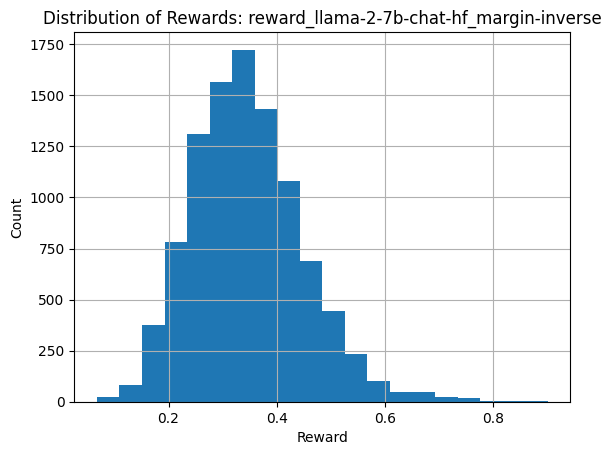

,0
count,10000.000000
mean,0.346597
std,0.103187
min,0.067547
25%,0.274351
50%,0.338077
75%,0.407805
max,0.901921


In [4]:
total_correct = 0
for row in eval_dataset:
    if row["reward_j"] > row["reward_k"]:
        total_correct += 1
accuracy = total_correct / len(eval_dataset)
print(f"Accuracy: {accuracy}")

all_rewards = []
for row in eval_dataset:
    all_rewards.append(row["reward_j"])
    all_rewards.append(row["reward_k"])

all_rewards_df = pd.DataFrame(all_rewards)
all_rewards_df.hist(bins=20)
plt.title(f'Distribution of Rewards: {model_name.split("/")[-2]}')
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()
all_rewards_df.describe()